# Wine Quality Predictor

The first section of this project will predict using only numpy calculations

I will use Dropout, the Adam Optimizer and and Minibatch Sampling on this Model 

In [1]:
import math
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import seaborn as sns

In [62]:
def softmax(X):
    exps = np.exp(X)
    return exps / np.sum(exps)

In [3]:
def d_sigmoid(dA, Z):   
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [4]:
def relu(Z):
    s = np.maximum(0,Z)
    return s

In [5]:
def d_relu(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    return dZ

## Dataset Loading

I load the dataset, shuffle it, and then section off the pieces for testing and training

I then use a MinMaxScaler on each row to normalize each input

In [39]:
def get_y(Y):
    b = np.zeros((10, Y.size))
    b[Y.astype(int), np.arange(Y.shape[1])] = 1
    return b

In [40]:
y = np.array([[7,5,6,5,4,4,8,9,6,7]])

b = get_Y(y)

print(b)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [41]:
# load the data from winequality dataset
# has about 5K entries
# data from https://machinelearningmastery.com/standard-machine-learning-datasets/

def loadDataset():
    data = np.genfromtxt("data/winequality-white.csv", delimiter = ";")
    data = np.delete(data, 0, axis = 0)
    
    np.random.shuffle(data)
    
    train, test = data[:3500, :], data[3500:, :]
    
    train_x = train[:,:-1].T
    train_y = train[:,-1].reshape(1, train.shape[0])
    
    train_x = preprocessing.minmax_scale(train_x, axis = 1)
    train_y = get_y(train_y)
    
    test_x = test[:,:-1].T
    test_y = test[:,-1].reshape(1, test.shape[0])
    
    test_x = preprocessing.minmax_scale(test_x, axis = 1)
    test_y = get_y(test_y)
    
    return (train_x, train_y, test_x, test_y)
    

3500


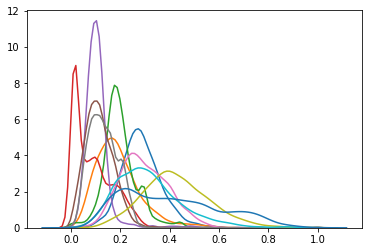

In [42]:
train_x, train_y, _, _ = loadDataset()

for i in range(train_x.shape[0]):
    sns.kdeplot(train_x[i])

print(train_y.shape[1])

## Hidden Layer Initialization

I use HE Initialization for the hidden layers, and zero initialization for the biases

HE initialization is when we start the weights by np.random.randn() * $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$


In [43]:
def initialize_parameters(layer_sizes):
    parameters = {}
    
    for i in range(1, len(layer_sizes)):
        parameters["W" + str(i)] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * math.sqrt(2/layer_sizes[i-1])
        parameters["b" + str(i)] = np.zeros((layer_sizes[i], 1))
        
    return parameters

In [44]:
parameters = initialize_parameters([11, 5, 5, 1])
print(len(parameters))

6


## Forward Propagation

We will implement forward proagation

This forward prop will store the Values of Z

We will also use RELU for all layers except the last where we will use SIGMOID

In [45]:
def forward_prop(X, parameters):
    layers = len(parameters) // 2
    
    cache = {}
    cache["A0"] = X
    
    
    for i in range(1, layers):
        cache["Z" + str(i)] = np.dot(parameters["W" + str(i)], cache["A" + str(i-1)]) + parameters["b" + str(i)]
        cache["A" + str(i)] = relu(cache["Z" + str(i)])
        
    cache["Z" + str(layers)] = np.dot(parameters["W" + str(layers)], cache["A" + str(layers - 1)]) + parameters["b" + str(layers)]
    cache["A" + str(layers)] = sigmoid(cache["Z" + str(layers)])
        
        
    return cache

## Back Propagation

We will implement back propagation

```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```



In [46]:
def back_prop(Y, parameters, cache):
    m = Y.shape[1]
    layers = len(cache) // 2
    
    grads = {}
    
    # initialize dAL
    dAL = - (np.divide(Y, cache["A" + str(layers)]) - np.divide(1 - Y, 1 - cache["A" + str(layers)]))
    
    grads["dZ" + str(layers)] = d_sigmoid(dAL, cache["Z" + str(layers)])
    
    grads["dW" + str(layers)] = 1/m * np.dot(grads["dZ" + str(layers)], cache["A" + str(layers - 1)].T)
    grads["db" + str(layers)] = 1/m * np.sum(grads["dZ" + str(layers)], axis = 1, keepdims = True)
    grads["dA" + str(layers - 1)] = np.dot(parameters["W" + str(layers)].T, grads["dZ" + str(layers)])
    
    for i in reversed(range(1, layers)):
        # using relu
        grads["dZ" + str(i)] = d_sigmoid(grads["dA" + str(i)], cache["Z" + str(layers)])
        
        grads["dW" + str(i)] = 1/m * np.dot(grads["dZ" + str(i)], cache["A" + str(i-1)].T)
        grads["db" + str(i)] = 1/m * np.sum(grads["dZ" + str(i)], axis=1, keepdims = True)
        grads["dA" + str(i - 1)] = np.dot(parameters["W" + str(i)].T, grads["dZ" + str(i)])
        
    return grads    

Cost function in using the softmax function


In [63]:
def compute_cost(cache, Y):
    A = cache["A" + str(len(cache) // 2)]
    m = Y.shape[1]
    
    losses = - np.sum(Y * np., axis = 1, keepdims = True)
    
    print(logprobs.shape)
    
    
    cost = (1/m) * np.sum(losses, axis = 1, keepdims = True)    
    cost = float(np.squeeze(cost))
    
    return cost

In [48]:
def update_parameters(parameters, grads, learning_rate):
    layers = len(parameters) // 2
    
    for i in range(layers):
        parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW" + str(i+1)]
        parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["d" + str(i+1)]

In [60]:
def model(X, Y, hidden_sizes, learning_rate, iterations):
    layer_sizes = hidden_sizes
    layer_sizes.insert(0, X.shape[0])
    layer_sizes.append(Y.shape[0])

    parameters = initialize_parameters(layer_sizes) 
    
    for i in range(iterations):
        
        cache = forward_prop(X, parameters)
        
        # grads = back_prop(Y, parameters, cache)
        # update_parameters(parameters, grads, learning_rate)
        
        
        if i%1000 == 0:
            cost = compute_cost(cache, Y)
            print("Cost after " + str(i) + " iterations is " + str(cost))
    
    return parameters

In [61]:
np.random.seed(1)

train_x, train_y, _, _ = loadDataset()

parameters = model(train_x, train_y, [4, 4], 1.2, 10000)

(10, 3500)


TypeError: only size-1 arrays can be converted to Python scalars